In [1]:
import datetime, time
import itertools
import numpy as np
import pandas as pd
import networkx as nx
from functools import reduce
from pyspark.sql import Window
from pyspark.sql import SparkSession
from pyspark.sql.types import (StructField, StringType,FloatType, 
                               DoubleType, IntegerType, StructType,
                              DateType)
from pyspark.sql import functions as F
from pyspark.sql import DataFrame as spDataFrame


from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import (Binarizer, OneHotEncoder, StringIndexer, HashingTF, 
                                Tokenizer, StandardScaler, VectorAssembler,
                               OneHotEncoder, StringIndexer, VectorIndexer)
from pyspark.ml.classification import LogisticRegression, LinearSVC, LinearSVCModel
from pyspark.ml.evaluation import HasFeaturesCol
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import os
import matplotlib.pyplot as plt

from sklearn.cross_validation import *
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.multiclass import OneVsOneClassifier
from sklearn.feature_selection import chi2, RFECV, SelectKBest
from sklearn.decomposition import PCA, NMF
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

#from tokenizer import Tokenizer

/usr/local/es7/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/es7/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


This is to setup the sparksession. If additional resources need to be allocated it is done with this command

# Import CSV Data

In [2]:
# proc_sample.columns

In [3]:
start_time = time.time()
master_df = pd.read_csv('../Dataset/Output/complete_df.csv')
print("--- %s seconds ---" % (time.time() - start_time))

--- 419.57237339019775 seconds ---


In [4]:
master_df.shape

(383485777, 15)

In [5]:
reduced_df = master_df[master_df['time']<=(3600*24*3)]

In [6]:
start_time = time.time()
reduced_df = reduced_df.copy()
reduced_df['time'] = pd.to_datetime(reduced_df['time'], unit='s').apply(lambda dt: dt.replace(year=2017))
print("--- %s seconds ---" % (time.time() - start_time))

--- 220.12392950057983 seconds ---


In [7]:
resampled_df = reduced_df.set_index('time').groupby('src_comp').resample('5min').agg({'redteam_event':'sum',
                                                                       'dns_count':'sum',
                                                                       'newresolved_count':'sum',
                                                                       'fail_count':'sum',
                                                                       'LoggedOn':'sum',
                                                                       'dur':'sum',
                                                                       'pkt_cnt':'sum',
                                                                       'byte_cnt':'sum',
                                                                       'avg_pkt_size':'mean',
                                                                       'proc_total':'sum',
                                                                       'proc_exec_total':'sum',
                                                                       'newexecute_count':'sum',
                                                                       'Proc_run':'sum'} ).reset_index().fillna(-999)

In [8]:
reduced_df.shape

(42099257, 15)

In [9]:
resampled_df.shape

(7812778, 15)

In [10]:
resampled_df['redteam_event'] = resampled_df.redteam_event.map(lambda x: 2 if x > 1 else x)

In [11]:
resampled_df.groupby('redteam_event').count()

,src_comp,time,dns_count,newresolved_count,fail_count,LoggedOn,dur,pkt_cnt,byte_cnt,avg_pkt_size,proc_total,proc_exec_total,newexecute_count,Proc_run
redteam_event,,,,,,,,,,,,,,
0.0,7812759,7812759,7812759,7812759,7812759,7812759,7812759,7812759,7812759,7812759,7812759,7812759,7812759,7812759
1.0,13,13,13,13,13,13,13,13,13,13,13,13,13,13
2.0,6,6,6,6,6,6,6,6,6,6,6,6,6,6


In [12]:
#master_df.groupby('redteam_event').count()

In [13]:
y = resampled_df.redteam_event
X = resampled_df[master_df.columns.difference(['redteam_event','src_comp','time'])]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33,stratify=y )

In [15]:
strtCV = StratifiedKFold(y_train, n_folds=4)

pipe = Pipeline([('reduce_dim', NMF()),
                  ('scale', StandardScaler()), 
                  ('clf', LogisticRegression())])

In [16]:
N_FEATURES_OPTIONS = [ 2, 5, 10]


C_OPTIONS = [1e-2, 1e-1, 1e0, 1e1]

In [17]:
rfc = RandomForestClassifier( random_state=0)
param_grid = [
    {
        'reduce_dim': [None],
        'scale':[None,StandardScaler()],
        'clf':[SVC(),LogisticRegression()],
        'clf__C': C_OPTIONS
    },
    {
        'reduce_dim': [None],
        'scale':[None,StandardScaler()],
        'clf':[SGDClassifier(tol=1e-3,max_iter=1000)],
        'clf__alpha': C_OPTIONS
    },
    {
        'reduce_dim': [NMF(),PCA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'scale':[None,StandardScaler()],
        'clf':[SVC(),LogisticRegression()],
        'clf__C': C_OPTIONS
    },
    {
        'reduce_dim': [NMF(),PCA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'scale':[None,StandardScaler()],
        'clf':[SGDClassifier(tol=1e-3,max_iter=1000)],
        'clf__alpha': C_OPTIONS
    } 
]
grid = GridSearchCV(pipe, param_grid, cv=strtCV, scoring='accuracy',verbose=1,n_jobs=-1)

In [18]:
grid.fit(X_train, y_train)


Fitting 4 folds for each of 168 candidates, totalling 672 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed: 131.2min
Process ForkPoolWorker-56:
Process ForkPoolWorker-14:
Process ForkPoolWorker-22:
Process ForkPoolWorker-46:
Process ForkPoolWorker-24:
Process ForkPoolWorker-31:
Process ForkPoolWorker-23:
Process ForkPoolWorker-37:
Process ForkPoolWorker-33:
Process ForkPoolWorker-54:
Process ForkPoolWorker-48:
Process ForkPoolWorker-47:
Process ForkPoolWorker-32:
Process ForkPoolWorker-8:
Process ForkPoolWorker-39:
Process ForkPoolWorker-1:
Process ForkPoolWorker-9:
Process ForkPoolWorker-3:
Process ForkPoolWorker-16:
Process ForkPoolWorker-18:
Process ForkPoolWorker-34:
Process ForkPoolWorker-2:
Process ForkPoolWorker-43:
  File "/usr/local/es7/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/es7/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/es7/lib

KeyboardInterrupt: 

In [ ]:
print("-grid.best_score_ {}".format(-grid.best_score_))
print("grid.best_params_ {}".format(grid.best_params_))
print("grid.best_estimator_ {}".format(grid.best_estimator_))

In [17]:
xgb_model = xgb.XGBClassifier()

#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['multi:softprob'],
              'learning_rate': [0.5,0.05,0.005], #so called `eta` value
              'max_depth': [6,7,8],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5,1000], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}


grid = GridSearchCV(xgb_model, parameters, n_jobs=-1, 
                   cv=strtCV, 
                   scoring='accuracy',
                   verbose=1, refit=True)

grid.fit(X_train, y_train)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

[20:51:20] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0. 0. ... 0. 0.], n_folds=4, shuffle=False, random_state=None),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'nthread': [4], 'objective': ['multi:softprob'], 'learning_rate': [0.5, 0.05, 0.005], 'max_depth': [6, 7, 8], 'min_child_weight': [11], 'silent': [1], 'subsample': [0.8], 'colsample_bytree': [0.7], 'n_estimators': [5, 1000], 'missing': [-999], 'seed': [1337]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [18]:
print("-grid.best_score_ {}".format(-grid.best_score_))
print("grid.best_params_ {}".format(grid.best_params_))
print("grid.best_estimator_ {}".format(grid.best_estimator_))

-grid.best_score_ -0.9999975165061598
grid.best_params_ {'colsample_bytree': 0.7, 'learning_rate': 0.5, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 5, 'nthread': 4, 'objective': 'multi:softprob', 'seed': 1337, 'silent': 1, 'subsample': 0.8}
grid.best_estimator_ XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=6, min_child_weight=11, missing=-999, n_estimators=5,
       n_jobs=1, nthread=4, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=1,
       subsample=0.8)


In [20]:
y_pred = grid.predict(X_test)

/usr/local/es7/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [21]:
confusion_matrix(y_test,y_pred)

array([[2578211,       0,       0],
       [      4,       0,       0],
       [      2,       0,       0]])

In [99]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[13892747        0]
 [       8        0]]
Normalized confusion matrix
[[ 1.  0.]
 [ 1.  0.]]


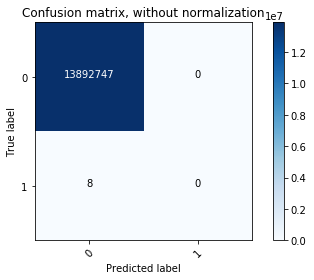

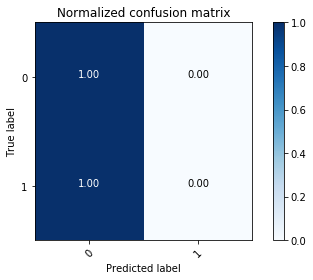

In [106]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names = ['0','1']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')

plt.show()

# Combine Data

This section I tried transforming the dataframes into pandas dataframes. This works, sort of, but it is very slow.

# Create Classification model

In [ ]:
cv = StratifiedKFold(n_splits=6)
classifier = xgb.XGBClassifier()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    print('round ',i+1)
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()